In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys
sys.path.append("../src/CellSNAP/")
from utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from preprocessing import *
from datasets import *

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from cellsnap import *

## Step I: Create spatial dataset

In [3]:
df = pd.read_csv('../../data/smi_tap/TMA4/processed_data/meta_data/features_and_metadata.csv', index_col = 0)

In [5]:
df

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,height,CD3,CD45,CD298,PanCK,DAPI,tma,tma_fov,RNA_snn_res.0.5,seurat_clusters
cell2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94,15.820,10.0010,18.334,27.929,76.41,4,4_2,21,21
cell3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22,15.135,9.8351,26.591,87.482,345.32,4,4_2,21,21
cell4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22,16.048,14.2470,57.477,15.119,1435.20,4,4_2,6,6
cell5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32,16.363,11.6250,52.470,141.080,241.20,4,4_2,21,21
cell6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22,15.742,12.2440,70.086,13.920,3200.20,4,4_2,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell81658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62,12.661,10.8140,103.670,23.511,559.47,4,4_21,6,6
cell81660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44,12.065,12.0130,37.594,75.039,1270.30,4,4_21,4,4
cell81663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46,13.670,11.6930,71.362,206.530,823.70,4,4_21,5,5
cell81667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36,12.690,11.2810,137.780,80.653,730.24,4,4_21,8,8


In [5]:
list(df['fov'].unique())

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21]

In [6]:
features_list = list(df.columns.values[:979])
fov_list = list(df['fov'].unique())

In [7]:
smiuter_dataset = SNAP_Dataset(df,
                               k=30,
                               feature_neighbor=15,
                               pca_components=25,
                               fov_list=fov_list,
                               features_list=features_list,
                               path2img='../../data/tutorial/smi_uter/processed_images')

## Initialize Dataset

In [8]:
smiuter_dataset.initialize("cent_X", "cent_Y", "seurat_clusters")

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Calculating cell neighborhood composition matrix...


In [9]:
smiuter_dataset.cell_nbhd

array([[0.        , 0.        , 0.03333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.36666667, 0.03333333, 0.        , ..., 0.        , 0.03333333,
        0.        ],
       [0.        , 0.03333333, 0.03333333, ..., 0.03333333, 0.        ,
        0.        ],
       [0.06666667, 0.1       , 0.03333333, ..., 0.        , 0.        ,
        0.        ]])

### Process Images

We first read in the raw images and make a list of images from all field of views.

In [10]:
images = []
for fov in smiuter_dataset.fov_list:
    image = np.transpose(imread(f'../../data/smi_tap/TMA4/image_snap/4_{fov}.TIF'), (1, 2, 0))
    images.append(image)

In [11]:
size = 512
truncation = 0.9
smiuter_dataset.prepare_images(images,
                               size,
                               truncation,
                               aggr = [[0, 1, 2, 3], [4]],
                               pad=1000,
                               verbose=False)

Saving images...


100%|████████████████████████████████████████████████████████████████████████████████| 3715/3715 [00:19<00:00, 187.27it/s]


## Step II: Train CellSNAP


There are two steps for training CellSNAP:
    1. Train SNAP-CNN to get CNN embedding
    2. Train SNAP-GNN to get GNN embedding

### Train SNAP-GNN

In [10]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
smiuter_cellsnap = CellSNAP(smiuter_dataset,
                           device,
                           cnn_model=True,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32)

In [ ]:
smiuter_cellsnap.fit_snap_cnn(
                     batch_size=64,
                     learning_rate=1e-4,
                     n_epochs=3,
                     loss_fn='MSELoss',
                     OptimizerAlg='Adam',
                     optimizer_kwargs=None,
                     SchedulerAlg=None,
                     scheduler_kwargs=None,
                     print_every=1)

In [ ]:
smiuter_cellsnap.pred_cnn_embedding(batch_size=512, path2result='../data/smi_uter/results')

We can also load a pretrained embedding if available.

In [12]:
smiuter_cellsnap.cnn_embedding = np.load('../data/smi_uter/results/SNAP_CNN_embedding.npy')

### Train SNAP GNN


In [14]:
smiuter_cellsnap.fit_snap_gnn(learning_rate=1e-3,
                             n_epochs=5000,
                             loss_fn='MSELoss',
                             OptimizerAlg='Adam',
                             optimizer_kwargs=None,
                             SchedulerAlg=None,
                             scheduler_kwargs=None,
                             print_every=500,
                             verbose=True)

===Epoch 500, the training loss is 0.00324095==
===Epoch 1000, the training loss is 0.00306178==
===Epoch 1500, the training loss is 0.00297309==
===Epoch 2000, the training loss is 0.00292923==
===Epoch 2500, the training loss is 0.00287934==
===Epoch 3000, the training loss is 0.00284949==
===Epoch 3500, the training loss is 0.00281263==
===Epoch 4000, the training loss is 0.00279685==
===Epoch 4500, the training loss is 0.00277249==
===Epoch 5000, the training loss is 0.00278123==

=========Save CellSNAP Embedding!============



## Step III: Visualization

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:260: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


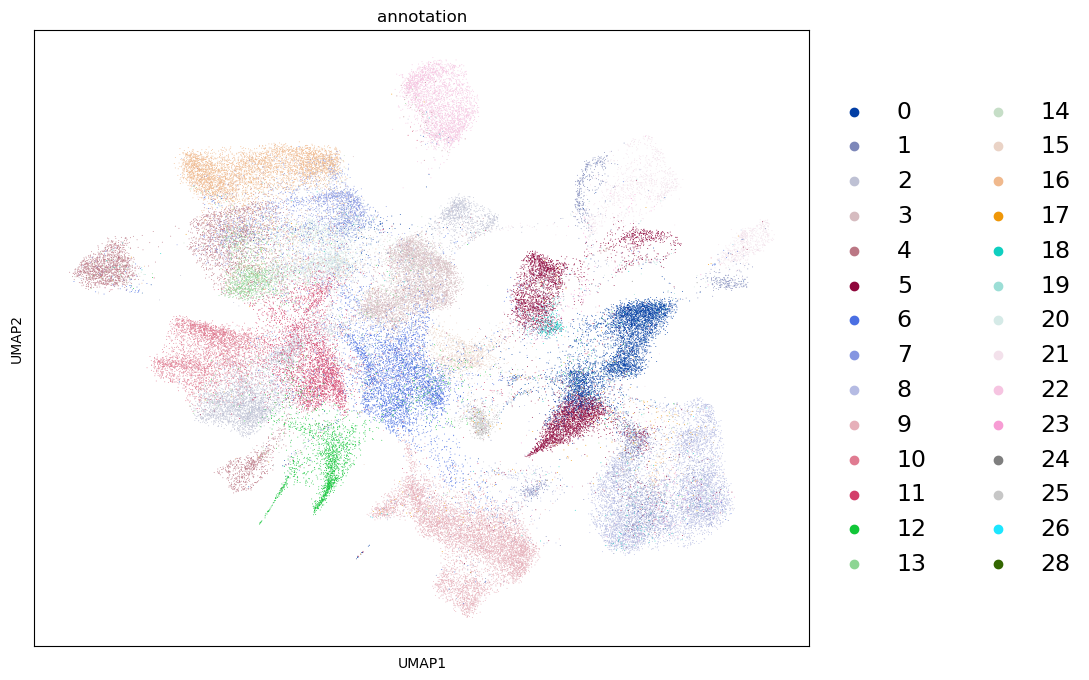

In [19]:
smiuter_cellsnap.visualize_umap(smiuter_dataset.features, smiuter_dataset.df['seurat_clusters'].astype(str))

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


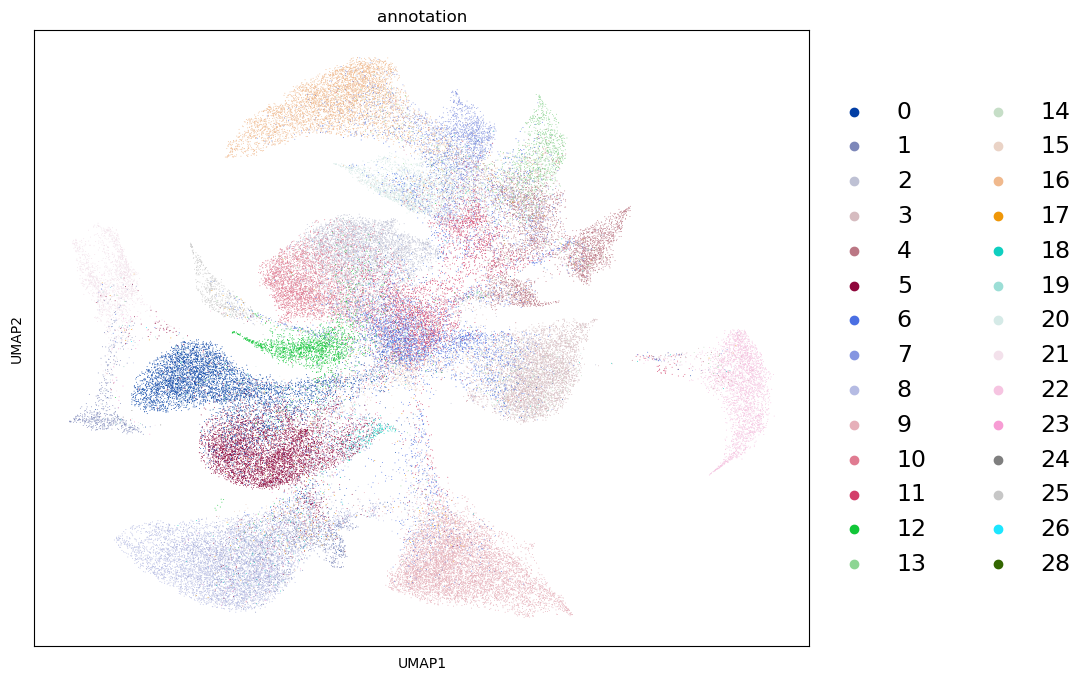

In [23]:
smiuter_cellsnap.visualize_umap(smiuter_cellsnap.embedding, smiuter_dataset.df['seurat_clusters'].astype(str))

## Train CellSNAP without morphology


In [25]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
smiuter_cellsnap = CellSNAP(smiuter_dataset,
                           device,
                           cnn_model=False,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32)

In [26]:
smiuter_cellsnap.fit_snap_gnn(learning_rate=1e-3,
                             n_epochs=5000,
                             loss_fn='MSELoss',
                             OptimizerAlg='Adam',
                             optimizer_kwargs=None,
                             SchedulerAlg=None,
                             scheduler_kwargs=None,
                             print_every=500,
                             verbose=True)

===Epoch 500, the training loss is 0.00341972==
===Epoch 1000, the training loss is 0.00324365==
===Epoch 1500, the training loss is 0.00316827==
===Epoch 2000, the training loss is 0.00310926==
===Epoch 2500, the training loss is 0.00307335==
===Epoch 3000, the training loss is 0.00303045==
===Epoch 3500, the training loss is 0.00299654==
===Epoch 4000, the training loss is 0.00297033==
===Epoch 4500, the training loss is 0.00293855==
===Epoch 5000, the training loss is 0.00291290==

=========Save CellSNAP Embedding!============



/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


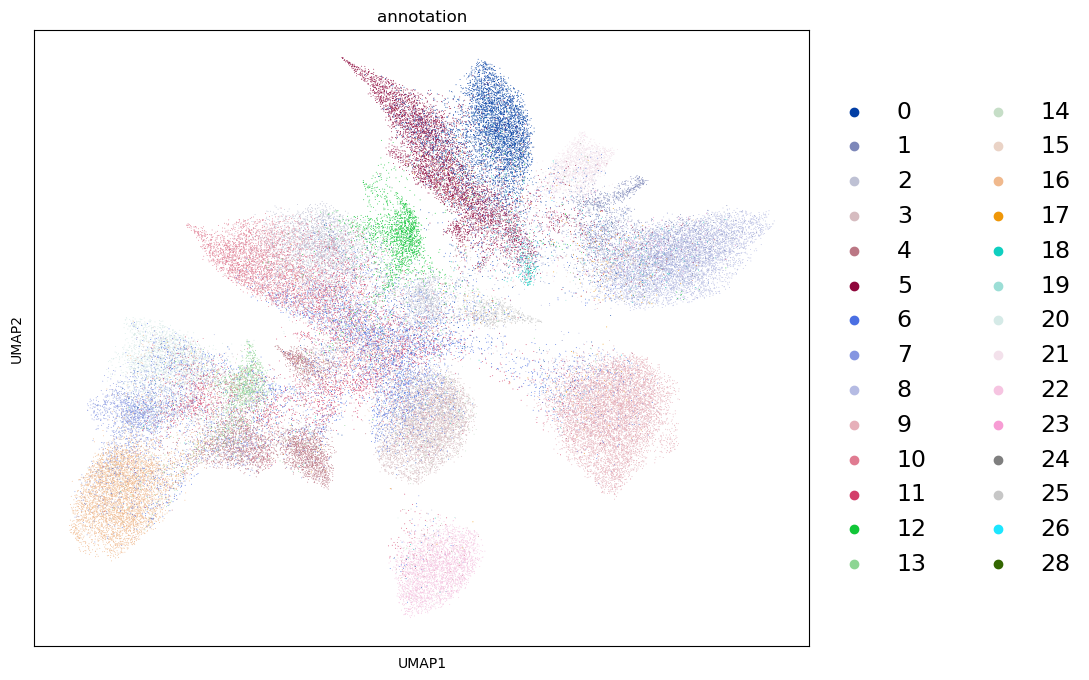

In [27]:
smiuter_cellsnap.visualize_umap(smiuter_cellsnap.embedding, smiuter_dataset.df['seurat_clusters'].astype(str))